# Converting Image Files (.h5) to PNG
#### Loading necessary modules

In [1]:
import sys
import h5py
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

## Use this section for polarized plots
### Uses plot_pol.py
- Run this block to create images with this formatting:
    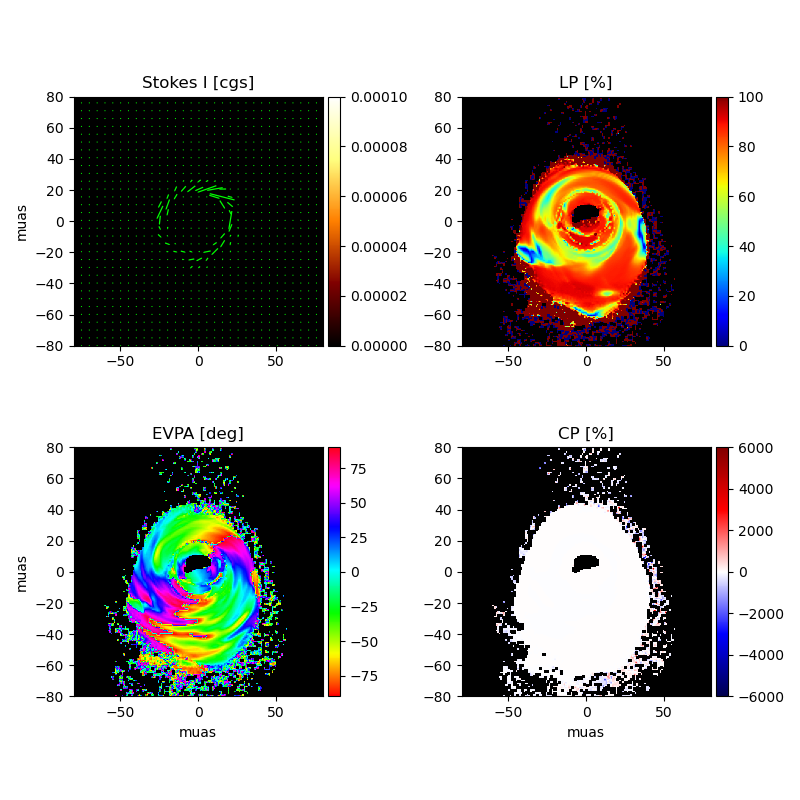
- To run this section:
    - First make sure your .h5 files are in the same directory or that you know the path to them
    - Put the name of your .h5 file in line 48
        - NOTE THAT THIS BLOCK CURRENTLY ONLY PRODUCES ONE IMAGE AT A TIME
    - Your resulting PNG will be in the same directory as your .h5 files
    - Below the block of code, you will see some values:
        - Flux [Jy]
        - I,Q,U,V [Jy] (Stokes Parameters)
        - LP [%] (Linear Polarization)
        - CP [%] (Circular Polarization)
        - EVPA [deg] (Electric Vector Polarization Angle)

In [9]:
"""
  Uses plot_pol.py
  Makes images from hdf5 output of ipole.
  2019.07.10 gnw

$ python ipole_plot.py path/to/images/*h5

$ ffmpeg -framerate 8 -i dump%*.png -s:v 1280x720 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p out.mp4
"""

import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
import numpy as np
import h5py
import sys


## configuration / plot parameters

FOV_UNITS = "muas"  # can be set to "muas" or "M" (case sensitive)

## EVPA_CONV not yet implemented! this will only work for observer convention!
EVPA_CONV = "EofN"  # can be set fo "EofN" or "NofW" 



## no need to touch anything below this line

def colorbar(mappable):
    """ the way matplotlib colorbar should have been implemented """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

if __name__ == "__main__":
    
    for fname in sys.argv[1:]:
        
        if fname[-3:] != ".h5": continue
            
        print("plotting {0:s}".format(fname))

    # load
    fname = "image_Sa-0.5_4000.h5"
    hfp = h5py.File(fname,'r')    
    dx = hfp['header']['camera']['dx'][()]
    dsource = hfp['header']['dsource'][()]
    lunit = hfp['header']['units']['L_unit'][()]
    fov_muas = dx / dsource * lunit * 2.06265e11
    scale = hfp['header']['scale'][()]
    evpa_0 = 'W'
    if 'evpa_0' in hfp['header']:
        evpa_0 = hfp['header']['evpa_0'][()]
        unpol = np.copy(hfp['unpol']).transpose((1,0))
        imagep = np.copy(hfp['pol']).transpose((1,0,2))
        I = imagep[:,:,0]
        Q = imagep[:,:,1]
        U = imagep[:,:,2]
        V = imagep[:,:,3]
        hfp.close()

    # set extent (assumption of square image)
    if FOV_UNITS == "muas":
        extent = [ -fov_muas/2, fov_muas/2, -fov_muas/2, fov_muas/2 ]
    elif FOV_UNITS == "M":
        extent = [ -dx/2, dx/2, -dx/2, dx/2 ]
    else:
        print("! unrecognized units for FOV {0:s}. quitting.".format(FOV_UNITS))

    # create plots
    plt.close('all')
    plt.figure(figsize=(8,8))
    ax1 = plt.subplot(2,2,1)
    ax2 = plt.subplot(2,2,2)
    ax3 = plt.subplot(2,2,3)
    ax4 = plt.subplot(2,2,4)

    # get mask for total intensity based on negative values
    Imaskval = np.abs(I.min()) * 100.
    Imaskval = np.nanmax(I) / np.power(I.shape[0],5.)

    # total intensity
    im1 = ax1.imshow(I, cmap='afmhot', vmin=0., vmax=np.max(I), origin='lower', extent=extent)#vmax=1.e-4
    colorbar(im1)

    # linear polarization fraction
    lpfrac = 100.*np.sqrt(Q*Q+U*U)/I
    lpfrac[np.abs(I)<Imaskval] = np.nan
    ax2.set_facecolor('black')
    im2 = ax2.imshow(lpfrac, cmap='jet', vmin=0., vmax=100., origin='lower', extent=extent)
    colorbar(im2)

    # circular polarization fraction
    cpfrac = 100.*V/I
    cpfrac[np.abs(I)<Imaskval] = np.nan
    vext = max(np.abs(np.nanmin(cpfrac)),np.abs(np.nanmax(cpfrac)))
    vext = max(vext, 1.)
    if np.isnan(vext): vext = 10.
    ax4.set_facecolor('black')
    im4 = ax4.imshow(cpfrac, cmap='seismic', vmin=-vext, vmax=vext, origin='lower', extent=extent)
    colorbar(im4)

    # evpa
    evpa = (180./3.14159)*0.5*np.arctan2(U,Q)
    if evpa_0 == "W":
        evpa += 90.
        evpa[evpa > 90.] -= 180.
    if EVPA_CONV == "NofW":
        evpa += 90.
        evpa[evpa > 90.] -= 180.
    evpa2 = np.copy(evpa)
    evpa2[np.abs(I)<Imaskval] = np.nan
    ax3.set_facecolor('black')
    im3 = ax3.imshow(evpa2, cmap='hsv', vmin=-90., vmax=90., origin='lower', extent=extent)
    colorbar(im3)

    # quiver on intensity
    npix = I.shape[0]
    xs = np.linspace(-fov_muas/2,fov_muas/2,npix)
    Xs,Ys = np.meshgrid(xs,xs)
    lpscal = np.max(np.sqrt(Q*Q+U*U))
    vxp = np.sqrt(Q*Q+U*U)*np.sin(evpa*3.14159/180.)/lpscal
    vyp = -np.sqrt(Q*Q+U*U)*np.cos(evpa*3.14159/180.)/lpscal
    skip = int(npix/32) 
    ax1.quiver(Xs[::skip,::skip],Ys[::skip,::skip],vxp[::skip,::skip],vyp[::skip,::skip], 
      headwidth=1, headlength=1, 
      width=0.005,
      color='#00ff00', 
      units='width', 
      scale=4,
      pivot='mid')

    # command line output
    print("Flux [Jy]:    {0:g} {1:g}".format(I.sum()*scale, unpol.sum()*scale))
    print("I,Q,U,V [Jy]: {0:g} {1:g} {2:g} {3:g}".format(I.sum()*scale,Q.sum()*scale,U.sum()*scale,V.sum()*scale))
    print("LP [%]:       {0:g}".format(100.*np.sqrt(Q.sum()**2+U.sum()**2)/I.sum()))
    print("CP [%]:       {0:g}".format(100.*V.sum()/I.sum()))
    evpatot = 180./3.14159*0.5*np.arctan2(U.sum(),Q.sum())
    if evpa_0 == "W":
        evpatot += 90. 
        if evpatot > 90.:
            evpatot -= 180
    if EVPA_CONV == "NofW":
        evpatot += 90.
        if evpatot > 90.:
            evpatot -= 180
    print("EVPA [deg]:   {0:g}".format(evpatot))

    # formatting and text
    ax1.set_title("Stokes I [cgs]")
    ax2.set_title("LP [%]")
    ax3.set_title("EVPA [deg]")
    ax4.set_title("CP [%]")
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    ax3.set_aspect('equal')
    ax4.set_aspect('equal')
    ax1.set_ylabel(FOV_UNITS)
    ax3.set_ylabel(FOV_UNITS)
    ax3.set_xlabel(FOV_UNITS)
    ax4.set_xlabel(FOV_UNITS)

    # saving
   # %matplotlib notebook
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #plt.show()
    plt.savefig(fname.replace(".h5",".png"))
    


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'image_Sa-0.5_4000.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Use this section for unpolarized plots
### Also uses an older .py file from IPOLE

- Run this block to create images with this formatting:
    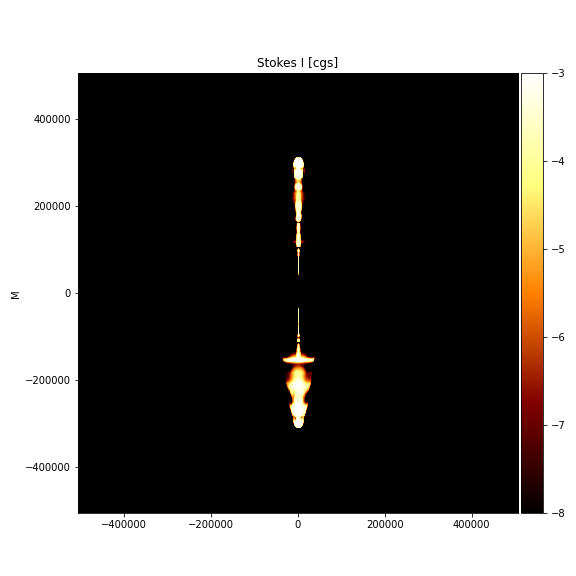
- To run this section:
    - First make sure your .h5 files are in the same directory or that you know the path to them
    - Put the name of your .h5 file in line 38
        - NOTE THAT THIS BLOCK CURRENTLY ONLY PRODUCES ONE IMAGE AT A TIME
    - Your resulting PNG will be in the same directory as your .h5 files

#### This block should mainly be used with KORAL simulations or in situations where you're not dealing with polarization

In [ ]:
import matplotlib
#matplotlib.use("agg")
import matplotlib.pyplot as plt
import numpy as np
import h5py
import sys


## configuration / plot parameters

FOV_UNITS = "M"  # can be set to "muas" or "M" (case sensitive)

## EVPA_CONV not yet implemented! this will only work for observer convention!
EVPA_CONV = "EofN"  # can be set fo "EofN" or "NofW" 



## no need to touch anything below this line

def colorbar(mappable):
#the way matplotlib colorbar should have been implemented 
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

if __name__ == "__main__":

    for fname in sys.argv[1:]:

        if fname[-3:] != ".h5": continue
    
    print("plotting {0:s}".format(fname))

    # load
    fname = "upolimage_ipole0780.h5"
    hfp = h5py.File(fname,'r')    
    dx = hfp['header']['camera']['dx'][()]
    dsource = hfp['header']['dsource'][()]
    lunit = hfp['header']['units']['L_unit'][()]
    fov_muas = dx / dsource * lunit * 2.06265e11
    scale = hfp['header']['scale'][()]
    evpa_0 = 'W'
    if 'evpa_0' in hfp['header']:
        evpa_0 = hfp['header']['evpa_0'][()]
    unpol = np.copy(hfp['unpol']).transpose((1,0))
    """
    imagep = np.copy(hfp['pol']).transpose((1,0,2))
    I = imagep[:,:,0]
    Q = imagep[:,:,1]
    U = imagep[:,:,2]
    V = imagep[:,:,3]
    """
    I = unpol
    Q = unpol
    U = unpol
    V = unpol
    hfp.close()

    # set extent (assumption of square image)
    if FOV_UNITS == "muas":
        extent = [ -fov_muas/2, fov_muas/2, -fov_muas/2, fov_muas/2 ]
    elif FOV_UNITS == "M":
        extent = [ -dx/2, dx/2, -dx/2, dx/2 ]
    else:
        print("! unrecognized units for FOV {0:s}. quitting.".format(FOV_UNITS))

    extent = np.multiply(extent,5.)

    # create plots
    plt.close('all')
    plt.figure(figsize=(8,8))
    ax1 = plt.subplot(1,1,1)

    # get mask for total intensity based on negative values
    Imaskval = np.abs(I.min()) * 100.
    Imaskval = np.nanmax(I) / np.power(I.shape[0],5.)

    # total intensity
    I = np.add(I,1.e-50)
    vmax = 1.e-3
    #vmax = I.max() / np.sqrt(1.5)
    vmin = vmax*1.e-5 + 1.e-25
    #norm=LogNorm(vmin=0.01, vmax=1)
    im1 = ax1.imshow(np.log10(I), cmap='afmhot', vmin=np.log10(vmin), vmax=np.log10(vmax), origin='lower', extent=extent)
    #im1 = ax1.imshow(I, cmap='afmhot', vmin=0., vmax=vmax, origin='lower', extent=extent)
    colorbar(im1)

    print("{0:g}".format(unpol.sum()*scale))
    # command line output
    #print("Flux [Jy]:    {0:g} {1:g}".format(I.sum()*scale, unpol.sum()*scale))
    #print("I,Q,U,V [Jy]: {0:g} {1:g} {2:g} {3:g}".format(I.sum()*scale,Q.sum()*scale,U.sum()*scale,V.sum()*scale))
    #print("LP [%]:       {0:g}".format(100.*np.sqrt(Q.sum()**2+U.sum()**2)/I.sum()))
    #print("CP [%]:       {0:g}".format(100.*V.sum()/I.sum()))
    evpatot = 180./3.14159*0.5*np.arctan2(U.sum(),Q.sum())

    # formatting and text
    #ax1.text(0,60000,"d=10000 kpc, F_nu [Jy] = "+str(unpol.sum()*scale)) 
    ax1.set_title("Stokes I [cgs]")
    #ax1.set_aspect('equal')
    ax1.set_ylabel(FOV_UNITS)

    # saving
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(fname.replace(".h5",".png"))
    #plt.show()

# Use this section for Richard's Formatting
#### This is the formatting we use in the papers and should be the main block you use
- Here's an example image:
    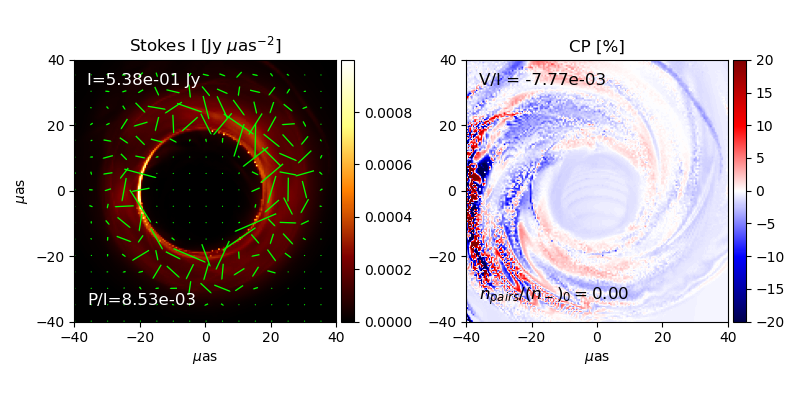
- Producing images with this formatting is a little more complicated so we have a slightly different set of instructions:
    - Whether or not you are running one file or many files through the code, ___run the block of code directly below this block___ 
        - It acts much like the block of modules at the beginning of this notebook
    - ___Once you run this blcok, proceed to the sections describing how to create one image or multiple images at once___

In [1]:
import re, h5py

def infer_positron_ratio(path):
    # try filename like ..._pos0_ or ..._pos1_
    m = re.search(r'_pos(\d)(?:_|\.|$)', path)
    if m:
        return float(m.group(1))
    # fallback: read from HDF5 header if present
    try:
        with h5py.File(path, "r") as f:
            for k in ["/header/positronRatio", "/header/positron_ratio", "/header/positron"]:
                if k in f:
                    return float(f[k][()])
    except Exception:
        pass
    return None


In [2]:
%matplotlib
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os, re, h5py
import numpy as np
from pathlib import Path
#from folderToMovie import *

def _infer_positron_ratio(imageFile: str):
    stem = Path(imageFile).stem  # no .h5
    # case 1: our pattern ..._pos<val>
    m = re.search(r'(?:^|_)pos(?P<val>[\d.]+)$', stem)
    if m:
        return float(m.group('val'))
    # case 2: last token is purely numeric ..._<val>
    last = stem.split('_')[-1]
    try:
        return float(last)
    except ValueError:
        pass
    # case 3: try to read from file (if the build writes it)
    try:
        with h5py.File(imageFile, "r") as H:
            return float(H["header"]["electrons"]["positronRatio"][()])
    except Exception:
        return float("nan")  # unknown but don't crash

def colorbar(mappable):
    """ the way matplotlib colorbar should have been implemented """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

def plotPositronTestFrame(imageFile, intensityMax=3e-3, cpMax=1e-2, output=None, EVPA_CONV="EofN", fractionalCircular=True):

    #Open the IPOLE output and extract relevant data.
    
    with h5py.File(imageFile, 'r') as hfp:
        dx = hfp['header']['camera']['dx'][()]
        dy = hfp['header']['camera']['dy'][()]
        dsource = hfp['header']['dsource'][()]
        lunit = hfp['header']['units']['L_unit'][()]
        fov_muas = dx / dsource * lunit * 2.06265e11
        scale = hfp['header']['scale'][()]
        evpa_0 = 'W'
        if 'evpa_0' in hfp['header']:
            evpa_0 = hfp['header']['evpa_0'][()]
        unpol = np.copy(hfp['unpol']).transpose((1,0)) * scale
        imagep = np.copy(hfp['pol']).transpose((1,0,2)) * scale
        pixelSize = dx * dy * (lunit / dsource * 2.06265e11)**2 / (imagep.shape[0] * imagep.shape[1])
        I = imagep[:,:,0] / pixelSize
        Q = imagep[:,:,1] / pixelSize
        U = imagep[:,:,2] / pixelSize
        V = imagep[:,:,3] / pixelSize
        fov_muas = 1*fov_muas # Find 86GHz FoV, 230GHz FoV in ipole_positron_Test_unlocked.py; Increasing fov_muas here zooms in                                         
    extent = [ -1*fov_muas/2, 1*fov_muas/2, -1*fov_muas/2, 1*fov_muas/2 ]

    #Initialize a plot with two panels.
    fig, axarr = plt.subplots(1, 2, figsize=(8,4))
    ax1 = axarr[0]
    ax2 = axarr[1]

    #Total intensity and linear polarization ticks.
    #Is = np.sum(I)
    im1 = ax1.imshow(I, cmap='afmhot', vmin=0., vmax=np.max(I), origin='lower', extent=extent) #vmax=intensityMax
    # intensityMax; vmax=np.max(I)
    colorbar(im1)
    #print(Is)
    #print('V/I = {0:1.2e}'.format(np.sum(V)/np.sum(I)))
    
    #Circular polarization fraction
    if fractionalCircular:
        cpfrac = 100.*V/I
        im2 = ax2.imshow(cpfrac, cmap='seismic', vmin=-cpMax, vmax=cpMax, origin='lower', extent=extent)
        colorbar(im2)
        ax2.set_title("CP [%]")
    else:
        im2 = ax2.imshow(V, cmap='seismic', vmin=-cpMax/100.0*intensityMax, vmax=cpMax/100.0*intensityMax, origin='lower', extent=extent)
        colorbar(im2)
        ax2.set_title("CP [Jy $\mu$as$^{-2}$]")

    #evpa
    evpa = (180./3.14159)*0.5*np.arctan2(U,Q)
    if evpa_0 == "W":
        evpa += 90.
        evpa[evpa > 90.] -= 180.
    if EVPA_CONV == "NofW":
        evpa += 90.
        evpa[evpa > 90.] -= 180.

    #quiver on intensity
    npix = I.shape[0]
    xs = np.linspace(-fov_muas/2,fov_muas/2,npix)
    Xs,Ys = np.meshgrid(xs,xs)
    lpscal = np.max(np.sqrt(Q*Q+U*U))
    vxp = np.sqrt(Q*Q+U*U)*np.sin(evpa*3.14159/180.)/lpscal
    vyp = -np.sqrt(Q*Q+U*U)*np.cos(evpa*3.14159/180.)/lpscal
    skip = int(npix/32)
    ax1.quiver(Xs[::skip,::skip],Ys[::skip,::skip],vxp[::skip,::skip],vyp[::skip,::skip],
      headwidth=1, headlength=1,
      width=0.005,
      color='#00ff00',
      units='width',
      scale=4,
      pivot='mid')

    #Formatting
    ax1.set_title("Stokes I [Jy $\mu$as$^{-2}$]")
    ax1.set_ylabel('$\mu$as')
    ax1.set_xlabel('$\mu$as')
    ax2.set_xlabel('$\mu$as')
    for axis in [ax1,ax2]:
        axis.set_aspect('equal')
        axis.set_xlim([-1*40,1*40])
        axis.set_ylim([-1*40,1*40])
        axis.set_xticks(np.linspace(-1*40,1*40,1*5))
        axis.set_yticks(np.linspace(-1*40,1*40,1*5))

    #Label.  Note that the positron fraction was included as part of the file name.  See some basic calculations here.
    positronRatio = _infer_positron_ratio(imageFile)
    bbox = {'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.8}
    ax2.text(0.05, 0.05, r'$n_{pairs}/(n_-)_0=$' + '{0:1.2f}'.format(positronRatio), ha='left', va='bottom', transform=ax2.transAxes, fontsize=12)
    ax2.text(0.05, 0.95, 'V/I = {0:1.2e}'.format(np.sum(V)/np.sum(I)), ha='left', va='top', transform=ax2.transAxes, fontsize=12)
    ax1.text(0.05, 0.95, 'I={0:3.2e} Jy'.format(np.sum(I) * pixelSize), ha='left', va='top', transform=ax1.transAxes, fontsize=12, color='white')
    #ax1.text(0.05, 0.95, 'I={0:3.2f} Jy'.format(np.sum(I) * pixelSize), ha='left', va='top', transform=ax1.transAxes, fontsize=12, color='white')
    ax1.text(0.05, 0.05, 'P/I={0:1.2e}'.format(np.sqrt(np.sum(Q)**2 + np.sum(U)**2)/np.sum(I)), ha='left', va='bottom', transform=ax1.transAxes, fontsize=12, color='white')
    print(positronRatio, '{0:1.2e}'.format(np.sum(V)/np.sum(I)))
    fig.tight_layout()
    fig.savefig(imageFile.replace(".h5",".png"))
    '''if output is None:
        fig.show()
    else:
        fig.savefig(imageFile.replace(".h5",".png"))
        plt.close(fig)'''


Using matplotlib backend: agg


## Creating one image 
#### Use the block below to create images individually
- To run this block:
    - Put your file name or path to your file in the 'imageFile' variable
    - Adjust any parameters necessary in 'plotPositronTestFrame()' 
    - Run the block and your output will appear in the same directory of your file

In [7]:
"""#imageFile = 'F:/GRMHD Dumps/R-Beta/Sa_Rbeta_test_5000_1.000.h5'
#imageFile = "positronTest_SANEa_Pt5_fPt5BetaC1MOffset2Pt0e28MSlope2Pt5e1SigmaTransition2SigmaCut2KHARMAcpMax1fPos0rmax50.h5"
#imageFile ='G:/GRMHD Jet Dumps/CritbetaWjetTest_1.000.h5'
#imageFile ='C:/Users/lanio/Downloads/positron_test_MADa+Pt94dump5000_0.000.h5'
#imageFile = 'G:/Post Comparison Test/postcomptest_MAD5_em2_5e24_25000M_1.000.h5'
#imageFile = 'G:/MADpt94 recreation tests/postest4_recreation_MADapt94_5000_1.000.h5'"""
#imageFile = 'aricarte_test_Ma-PT53500_0.000.h5'

#imageFile = 'C:/Users/Hayley/Documents/Masters-UTSA/Research/ipole/output_images/MADS/RBETA/Positron_MAD+0.94dump6000-RBETA_0.000.h5'
imageFile = '/work/vmo703/ipole_outputs/fig13_MADa-0.5_RBETA_0.000.h5'
imageFile2 = '/work/vmo703/ipole_outputs/fig13_MADa-0.5_RBETA_1.000.h5'


plotPositronTestFrame(imageFile, cpMax=0.1, fractionalCircular=False)
plotPositronTestFrame(imageFile2, cpMax=0.1, fractionalCircular=False)
#plotPositronTestFrame(imageFile, intensityMax=3e-3, cpMax=20, output=None, EVPA_CONV="EofN", fractionalCircular=True)

0.0 -4.51e-03
1.0 -1.39e-03


In [42]:
import h5py, pathlib as p
for f in sorted(p.Path("/work/vmo703/ipole_outputs").glob("image_Sa-0.5_5000_RBETA_pos0.h5")):
    with h5py.File(f, "r") as H:
        tM = float(H["/fluid_header/t"][()])   # time in code units ~ M
        F  = float(H["/Ftot_unpol"][()])
    print(f.name, "  t[M] =", tM, "  Ftot[Jy] =", F)


image_Sa-0.5_5000_RBETA_pos0.h5   t[M] = 25000.00574440445   Ftot[Jy] = 0.2674505406203403


#### This block is defunct, skip it

In [ ]:
'''import sys
import os
import imageio
import glob

#path = 'movie_files/'
path = 'F:/GRMHD Dumps/Movie Files/'
#filenames = [path+'sc_positron_test_MADa+Pt94dump5000_0.000.png',path+'sc_positron_test_MADa+Pt94dump5000_0.750.png',path+'sc_positron_test_MADa+Pt94dump5000_1.500.png',path+'sc_positron_test_MADa+Pt94dump5000_2.250.png',path+'sc_positron_test_MADa+Pt94dump5000_3.000.png']
filenames=[]
for file in'F:/GRMHD Dumps/Movie Files/':
    filename = os.fsdecode(file)
    if filename.endswith(".png"): 
        filenames.append(filename)
    

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('test.gif', images)'''

## Creating multiple images
#### Use the block below to create many images at once
- To run this block:
    - Put the path to your files in line 50
        - Here's an example: makePositronTestMovie('path/to/files','moviename.mp4',temporaryFolder='../image files/frames/', fractionalCircular=True, cpMax=0.1)
        - note that the movies will not be produced here since ffmpeg no longer works
    - Adjust any parameters necessary in 'makePositronTestMovie()' 
    - Run the block and your output will appear in the same directory of your files
    - Note that below the block it will print your positron fraction and V/I value for each frame

In [5]:
import sys
import os
import imageio

def folderToMovie(inFolder, outMovie, framerate=8, patternMatch="%*.png"):
    if inFolder[-1] != '/':
        inFolder += '/'
    os.system("ffmpeg -y -framerate "+str(int(framerate))+" -i "+inFolder+patternMatch+" -s:v 1280x720 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p "+outMovie)

if __name__ == '__main__':
    inFolder = sys.argv[1]
    outMovie = sys.argv[2]
    folderToMovie(inFolder, outMovie)

#from folderToMovie import *
def makePositronTestMovie(imageFolder, movieName, temporaryFolder='../image files/frames/', fractionalCircular=True, cpMax=20.0, intensityMax=3e-3):

    #Sanitize input by adding a slash to the end if necessary.
    if imageFolder[-1] != '/':
        imageFolder += '/'
    if temporaryFolder[-1] != '/':
        temporaryFolder += '/'
        
    #WARNING:  Destroys all frames in the temporary folder.
    os.system('rm '+temporaryFolder+'frame*png')

    #In the image folder, there's a series of images which contain the positron fraction in the file name.  Interpret them.
    listOfImages = os.listdir(imageFolder)
    positronRatios = [(imageFile.split('_')[-1][:-3]) for imageFile in listOfImages]
    ordering = np.argsort(positronRatios)
    listOfImages = [listOfImages[order] for order in ordering]

    #Make a plot for each frame.
    for frame in range(len(listOfImages)):
        #print ( 'Creating frame {0} of {1}.'.format(frame+1, len(listOfImages)))#Added parentheses after download from Angelo
        plotPositronTestFrame(imageFolder + listOfImages[frame], output=temporaryFolder + 'frame{0:04}.png'.format(frame), \
        fractionalCircular=fractionalCircular, cpMax=cpMax, intensityMax=intensityMax)
        #print('V/I = {0:1.2e}'.format(np.sum(V)/np.sum(I)))

    #Convert the folder into a movie.
    folderToMovie(temporaryFolder, movieName)

if __name__ == '__main__':
    #These are example commands that I used...
#positronTest_MADaPt94_RHigh20BetaEPt01MOffset5Pt0e24MSlope1Pt5e0SigmaTransition0Pt5SigmaCut2KHARMAcpMaxPt1.mp4
#    makePositronTestMovie('../ipole_output/MAD_a+0.94_R20.0_positrons/', '../movies/positronTest_MAD.mp40',)/n/home13/anantua/ipole/aricarte/e+Output
#    makePositronTestMovie('/n/home13/anantua/ipole/aricarte/e+Output/', 'movies/positronTest_MAD_BetaE0Pt01SigmaTransition1SigmaCut2.mp4', fractionalCircular=False, cpMax=4)
    '''    makePositronTestMovie('C:/Users/lanio/Downloads/ipole-master/ipole-master/scripts/movie files', 'C:/Users/lanio/Downloads/ipole-master/ipole-master/scripts/movie files/test.mp4', fractionalCircular=False, cpMax=1e-1)#cpMax=4     
    '''
    makePositronTestMovie('G:/30000M RBeta/30000RBeta_apt94_rh20_MAD9pt0e24_2pt0e0_ST2SC2_cpmpt1','30000RBeta_apt94_rh20_MAD9pt0e24_2pt0e0_ST2SC2_cpmpt1.mp4',temporaryFolder='../image files/frames/', fractionalCircular=True, cpMax=0.1)#cpMax=4
    #folderToMovie(temporaryFolder, movieName)
#positronTest_SANEa-Pt5_RHigh20MOffset8Pt0e27MSlope2Pt0e1SigmaTransitionPt5SigmaCut2KHARMAcpMax1.mp4
#    makePositronTestMovie('../ipole_output/SANE_a+0.94_R20.0_positrons/', '../movies/positronTest_SANE.mp4', fractionalCircular=False, cpMax=20, intensityMax=1e-3)
#    makePositronTestMovie('ipole_output/SANE_a+0.94_R20.0_positrons/', 'movies/positronTest_SANE.mp4', fractionalCircular=False, cpMax=20, intensityMax=1e-3)
#    makePositronTestMovie('/n/home13/anantua/ipole/aricarte/e+Output/', 'movies/positronTest_SANEa-Pt5_fPt5BetaC1BetaEPt01MOffset7Pt5e27MSlope2Pt0e1SigmaTransition0Pt5SigmaCut2KHARMAcpMax1rMax50.mp4',fractionalCircular=False, cpMax=1e-0, intensityMax=1e-3)#cpMax=20,intensityMax=1e-3


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'G:/30000M RBeta/30000RBeta_apt94_rh20_MAD9pt0e24_2pt0e0_ST2SC2_cpmpt1/'

In [6]:
'''folderToMovie('F:/GRMHD Dumps/Movie Files', 'test.mp4')
makePositronTestMovie('F:/GRMHD Dumps','test.mp4',temporaryFolder='../image files/frames/', fractionalCircular=False, cpMax=1e-3)#cpMax=4'''

"folderToMovie('F:/GRMHD Dumps/Movie Files', 'test.mp4')\nmakePositronTestMovie('F:/GRMHD Dumps','test.mp4',temporaryFolder='../image files/frames/', fractionalCircular=False, cpMax=1e-3)#cpMax=4"

# Use this section for V/I Plots
## Still being written

In [7]:
#Extract V/I values.
vi = []
for frame in range(len(listOfImages)):
    print ( 'Creating frame {0} of {1}.'.format(frame+1, len(listOfImages)) )#Added parentheses after download from Angelo
    plotPositronTestFrame(imageFolder + listOfImages[frame], output=temporaryFolder + 'frame{0:04}.png'.format(frame), \
    fractionalCircular=fractionalCircular, cpMax=cpMax, intensityMax=intensityMax)


NameError: name 'listOfImages' is not defined

In [8]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os
import numpy as np
import h5py
from folderToMovie import *

def colorbar(mappable):
    """ the way matplotlib colorbar should have been implemented """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

def plotPositronTestFrame(imageFile, intensityMax=3e-3, cpMax=20, output=None, EVPA_CONV="EofN", fractionalCircular=True):

    #Open the IPOLE output and extract relevant data.
    with h5py.File(imageFile, 'r') as hfp:
        dx = hfp['header']['camera']['dx'][()]
        dy = hfp['header']['camera']['dy'][()]
        dsource = hfp['header']['dsource'][()]
        lunit = hfp['header']['units']['L_unit'][()]
        fov_muas = dx / dsource * lunit * 2.06265e11
        scale = hfp['header']['scale'][()]
        evpa_0 = 'W'
        if 'evpa_0' in hfp['header']:
          evpa_0 = hfp['header']['evpa_0'][()]
        unpol = np.copy(hfp['unpol']).transpose((1,0)) * scale
        imagep = np.copy(hfp['pol']).transpose((1,0,2)) * scale
        pixelSize = dx * dy * (lunit / dsource * 2.06265e11)**2 / (imagep.shape[0] * imagep.shape[1])
        I = imagep[:,:,0] / pixelSize
        Q = imagep[:,:,1] / pixelSize
        U = imagep[:,:,2] / pixelSize
        V = imagep[:,:,3] / pixelSize
    extent = [ -fov_muas/2, fov_muas/2, -fov_muas/2, fov_muas/2 ]

    #Initialize a plot with two panels.
    fig, axarr = plt.subplots(1, 2, figsize=(8,4))
    ax1 = axarr[0]
    ax2 = axarr[1]

    #Total intensity and linear polarization ticks.
    im1 = ax1.imshow(I, cmap='afmhot', vmin=0., vmax=intensityMax, origin='lower', extent=extent)
    colorbar(im1)

    #Circular polarization fraction
    if fractionalCircular:
        cpfrac = 100.*V/I
        im2 = ax2.imshow(cpfrac, cmap='seismic', vmin=-cpMax, vmax=cpMax, origin='lower', extent=extent)
        colorbar(im2)
        ax2.set_title("CP [%]")
    else:
        im2 = ax2.imshow(V, cmap='seismic', vmin=-cpMax/100.0*intensityMax, vmax=cpMax/100.0*intensityMax, origin='lower', extent=extent)
        colorbar(im2)
        ax2.set_title("CP [Jy $\mu$as$^{-2}$]")

    #evpa
    evpa = (180./3.14159)*0.5*np.arctan2(U,Q)
    if evpa_0 == "W":
      evpa += 90.
      evpa[evpa > 90.] -= 180.
    if EVPA_CONV == "NofW":
      evpa += 90.
      evpa[evpa > 90.] -= 180.

    #quiver on intensity
    npix = I.shape[0]
    xs = np.linspace(-fov_muas/2,fov_muas/2,npix)
    Xs,Ys = np.meshgrid(xs,xs)
    lpscal = np.max(np.sqrt(Q*Q+U*U))
    vxp = np.sqrt(Q*Q+U*U)*np.sin(evpa*3.14159/180.)/lpscal
    vyp = -np.sqrt(Q*Q+U*U)*np.cos(evpa*3.14159/180.)/lpscal
    skip = int(npix/32)
    ax1.quiver(Xs[::skip,::skip],Ys[::skip,::skip],vxp[::skip,::skip],vyp[::skip,::skip],
      headwidth=1, headlength=1,
      width=0.005,
      color='#00ff00',
      units='width',
      scale=4,
      pivot='mid')

    #Formatting
    ax1.set_title("Stokes I [Jy $\mu$as$^{-2}$]")
    ax1.set_ylabel('$\mu$as')
    ax1.set_xlabel('$\mu$as')
    ax2.set_xlabel('$\mu$as')
    for axis in [ax1,ax2]:
        axis.set_aspect('equal')
        axis.set_xlim([-40,40])
        axis.set_ylim([-40,40])
        axis.set_xticks(np.linspace(-40,40,5))
        axis.set_yticks(np.linspace(-40,40,5))

    #Label.  Note that the positron fraction was included as part of the file name.  See some basic calculations here.
    positronRatio = float(imageFile.split('_')[-1][:-3])
    bbox = {'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.8}
    ax2.text(0.05, 0.05, r'$n_{pairs}/(n_-)_0=$' + '{0:1.2f}'.format(positronRatio), ha='left', va='bottom', transform=ax2.transAxes, fontsize=12)
    ax2.text(0.05, 0.95, 'V/I = {0:1.2e}'.format(np.sum(V)/np.sum(I)), ha='left', va='top', transform=ax2.transAxes, fontsize=12)
    ax1.text(0.05, 0.95, 'I={0:3.2f} Jy'.format(np.sum(I) * pixelSize), ha='left', va='top', transform=ax1.transAxes, fontsize=12, color='white')
    ax1.text(0.05, 0.05, 'P/I={0:1.2e}'.format(np.sqrt(np.sum(Q)**2 + np.sum(U)**2)/np.sum(I)), ha='left', va='bottom', transform=ax1.transAxes, fontsize=12, color='white')

    fig.tight_layout()
    if output is None:
        fig.show()
    else:
        fig.savefig(output)
        plt.close(fig)

def makePositronTestMovie(imageFolder, movieName, temporaryFolder='../images/frames/', fractionalCircular=True, cpMax=20.0, intensityMax=3e-3):

    #Sanitize input by adding a slash to the end if necessary.
    if imageFolder[-1] != '/':
        imageFolder += '/'
    if temporaryFolder[-1] != '/':
       temporaryFolder += '/'

    #WARNING:  Destroys all frames in the temporary folder.
    os.system('rm '+temporaryFolder+'frame*png')

    #In the image folder, there's a series of images which contain the positron fraction in the file name.  Interpret them.
    listOfImages = os.listdir(imageFolder)
    positronRatios = [float(imageFile.split('_')[-1][:-3]) for imageFile in listOfImages]
    ordering = np.argsort(positronRatios)
    listOfImages = [listOfImages[order] for order in ordering]

    #Make a plot for each frame.
    for frame in range(len(listOfImages)):
        print ( 'Creating frame {0} of {1}.'.format(frame+1, len(listOfImages)) )#Added parentheses after download from Angelo
        plotPositronTestFrame(imageFolder + listOfImages[frame], output=temporaryFolder + 'frame{0:04}.png'.format(frame), \
        fractionalCircular=fractionalCircular, cpMax=cpMax, intensityMax=intensityMax)

    #Convert the folder into a movie.
    folderToMovie(temporaryFolder, movieName)

#if __name__ == '__main__':
    #These are example commands that I used...
#positronTest_MADaPt94_RHigh20BetaEPt01MOffset5Pt0e24MSlope1Pt5e0SigmaTransition0Pt5SigmaCut2KHARMAcpMaxPt1.mp4
#    makePositronTestMovie('../ipole_output/MAD_a+0.94_R20.0_positrons/', '../movies/positronTest_MAD.mp40',)/n/home13/anantua/ipole/aricarte/e+Output
#    makePositronTestMovie('/n/home13/anantua/ipole/aricarte/e+Output/', 'movies/positronTest_MAD_BetaE0Pt01SigmaTransition1SigmaCut2.mp4', fractionalCircular=False, cpMax=4)
#    makePositronTestMovie('/work/epc964/ipole_HarvardCannonHPC_copy/aricarte/e+Output/', 'movies/positronTest_MADa+Pt94_fPt5BetaC1MOffset7Pt5e24MSlope1Pt5e0SigmaTransition2SigmaCut2KHARMAcpMaxPt1T5000rMax50.mp4', fractionalCircular=False, cpMax=1e-1)#cpMax=4

#positronTest_SANEa-Pt5_RHigh20MOffset8Pt0e27MSlope2Pt0e1SigmaTransitionPt5SigmaCut2KHARMAcpMax1.mp4
#    makePositronTestMovie('../ipole_output/SANE_a+0.94_R20.0_positrons/', '../movies/positronTest_SANE.mp4', fractionalCircular=False, cpMax=20, intensityMax=1e-3)
#    makePositronTestMovie('ipole_output/SANE_a+0.94_R20.0_positrons/', 'movies/positronTest_SANE.mp4', fractionalCircular=False, cpMax=20, intensityMax=1e-3)
#    makePositronTestMovie('/n/home13/anantua/ipole/aricarte/e+Output/', 'movies/positronTest_SANEa-Pt5_fPt5BetaC1BetaEPt01MOffset7Pt5e27MSlope2Pt0e1SigmaTransition0Pt5SigmaCut2KHARMAcpMax1rMax50.mp4',fractionalCircular=False, cpMax=1e-0, intensityMax=1e-3)#cpMax=20,intensityMax=1e-3



ModuleNotFoundError: No module named 'folderToMovie'

In [9]:
"""#imageFile = 'F:/GRMHD Dumps/R-Beta/Sa_Rbeta_test_5000_1.000.h5'
#imageFile = "positronTest_SANEa_Pt5_fPt5BetaC1MOffset2Pt0e28MSlope2Pt5e1SigmaTransition2SigmaCut2KHARMAcpMax1fPos0rmax50.h5"
#imageFile ='G:/GRMHD Jet Dumps/CritbetaWjetTest_1.000.h5'
#imageFile ='C:/Users/lanio/Downloads/positron_test_MADa+Pt94dump5000_0.000.h5'
#imageFile = 'G:/Post Comparison Test/postcomptest_MAD5_em2_5e24_25000M_1.000.h5'
#imageFile = 'G:/MADpt94 recreation tests/postest4_recreation_MADapt94_5000_1.000.h5'"""
#imageFile = 'aricarte_test_Ma-PT53500_0.000.h5'

imageFile = 'C:/Users/Hayley/Documents/Masters-UTSA/Research/ipole/output_images/Positron_MAD-0.5dump6000-RBETA_1.000.h5'
plotPositronTestFrame(imageFile, cpMax=1e-1, fractionalCircular=False)
#plotPositronTestFrame(imageFile, intensityMax=3e-3, cpMax=20, output=None, EVPA_CONV="EofN", fractionalCircular=True)

NameError: name 'plotPositronTestFrame' is not defined

# analyzing script

In [10]:
import h5py
import numpy as np
from scipy.signal import fftconvolve, gaussian

def convolveSquareImage(image, fieldOfView, gaussian_fwhm):

    """

    Used for blurring.

    """

 

    assert image.shape[0] == image.shape[1]

 

    smoothingIndices = gaussian_fwhm / (fieldOfView / image.shape[0])

 

    kernel_1d = gaussian(np.floor(smoothingIndices*6/2.355), np.floor(smoothingIndices/2.355))

    kernel_1d /= np.sum(kernel_1d)

    kernel = np.outer(kernel_1d, kernel_1d)

    return fftconvolve(image, kernel, mode='same')

 

def computeBeta2(polarizedImageCube, fov_muas, r_min=0, r_max=np.inf, norm_in_int = False, norm_with_StokesI = True, ms=[2]):

    """

    Based on Daniel's pmodes.

    """

 

    npix = polarizedImageCube.shape[0]

    iarr = polarizedImageCube[:,:,0]

    qarr = polarizedImageCube[:,:,1]

    uarr = polarizedImageCube[:,:,2]

    varr = polarizedImageCube[:,:,3]

 

    parr = qarr + 1j*uarr

    normparr = np.abs(parr)

    marr = parr/iarr

    phatarr = parr/normparr

    area = (r_max*r_max - r_min*r_min) * np.pi

    pxi = (np.arange(npix)-0.01)/npix-0.5

    pxj = np.arange(npix).astype(float)/npix-0.5

    mui = pxi*fov_muas

    muj = pxj*fov_muas

    MUI,MUJ = np.meshgrid(mui,muj)

    MUDISTS = np.sqrt(np.power(MUI,2.)+np.power(MUJ,2.))

 

    # get angles measured East of North

    PXI,PXJ = np.meshgrid(pxi,pxj)

    angles = np.arctan2(-PXJ,PXI) - np.pi/2.

    angles[angles<0.] += 2.*np.pi

 

    # get flux in annulus

    tf = iarr [ (MUDISTS<=r_max) & (MUDISTS>=r_min) ].sum()

 

    # get total polarized flux in annulus

    pf = normparr [ (MUDISTS<=r_max) & (MUDISTS>=r_min) ].sum()

 

    #get number of pixels in annulus

    npix = iarr [ (MUDISTS<=r_max) & (MUDISTS>=r_min) ].size

 

    #get number of pixels in annulus with flux >= some % of the peak flux

    ann_iarr = iarr [ (MUDISTS<=r_max) & (MUDISTS>=r_min) ]

    peak = np.max(ann_iarr)

    num_above5 = ann_iarr[ann_iarr > .05* peak].size

    num_above10 = ann_iarr[ann_iarr > .1* peak].size

 

    # compute betas

    betas = []

    for m in ms:

        qbasis = np.cos(-angles*m)

        ubasis = np.sin(-angles*m)

        pbasis = qbasis + 1.j*ubasis

        if norm_in_int:

             if norm_with_StokesI:

                 prod = marr * pbasis

             else:

                 prod = phatarr * pbasis

             coeff = prod[ (MUDISTS <= r_max) & (MUDISTS >= r_min) ].sum()

             coeff /= npix

        else:

             prod = parr * pbasis

             coeff = prod[ (MUDISTS<=r_max) & (MUDISTS>=r_min) ].sum()

             if norm_with_StokesI:

                 coeff /= tf

             else:

                 coeff /= pf

        betas.append(coeff)

    return betas

 

def computeImageMoments(image, blurringGaussianFWHM=0.0):

    """

    Based on moments.py in blackholepy by CK Chan.

    """

 

    #Grab Stokes I and compute image field of view.

    with h5py.File(image, 'r') as openFile:

        img = openFile['pol'][()][:,:,0].transpose((1,0))

        dx = openFile['header']['camera']['dx'][()]

        dy = openFile['header']['camera']['dy'][()]

        dsource = openFile['header']['dsource'][()]

        lunit = openFile['header']['units']['L_unit'][()]

        width = dx / dsource * lunit * 2.06265e11

        height = dy / dsource * lunit * 2.06265e11

 

    #Convolve.  This is slow.

    if blurringGaussianFWHM > 0:

        assert width == height

        img = convolveSquareImage(img, width, blurringGaussianFWHM)

 

    s  = np.sum(img)

    w  = width  * ((np.arange(img.shape[-2]) + 0.5) / img.shape[-2] - 0.5)

    h  = height * ((np.arange(img.shape[-1]) + 0.5) / img.shape[-1] - 0.5)

 

    w0 = np.sum(w * np.sum(img, axis=-1)) / s # axis -2, so sum -1 first

    h0 = np.sum(h * np.sum(img, axis=-2)) / s # axis -1, so sum -2 first

    w -= w0

    h -= h0

 

    ww = np.sum(w * w * np.sum(img, axis=-1)) / s

    hh = np.sum(h * h * np.sum(img, axis=-2)) / s

    wh = np.sum(w[...,:,np.newaxis] * h[...,np.newaxis,:] * img) / s

 

    cc = 0.5 * (ww + hh)

    dd = 0.5 * (ww - hh)

    D  = np.sqrt(dd * dd + wh * wh)

 

    sigmaToFWHM = np.sqrt(8 * np.log(2))

    majorAxis = np.sqrt(cc + D) * sigmaToFWHM

    minorAxis = np.sqrt(cc - D) * sigmaToFWHM

 

    return majorAxis, minorAxis

 

 

def analyzeImage(filename, blurringKernel_fwhm_muas=20.0):

 

    with h5py.File(filename, 'r') as openFile:

        scale = openFile['header']['scale'][()]

        pol = openFile['pol'][()].transpose((1,0,2)) * scale

        I = pol[:,:,0]

        Q = pol[:,:,1]

        U = pol[:,:,2]

        P = np.sqrt(Q**2 + U**2)

        evpa = 0.5 * np.arctan2(U, Q) * 180.0/np.pi

        V = pol[:,:,3]

        dx = openFile['header']['camera']['dx'][()]

        dsource = openFile['header']['dsource'][()]

        lunit = openFile['header']['units']['L_unit'][()]

        fov_muas = dx / dsource * lunit * 2.06265e11

 

    totalFlux = np.sum(I)

    m_net = np.sum(P)/np.sum(I)

    v_net = np.sum(V)/np.sum(I)

    blurryImage_I = convolveSquareImage(I, fov_muas, blurringKernel_fwhm_muas)

    blurryImage_Q = convolveSquareImage(Q, fov_muas, blurringKernel_fwhm_muas)

    blurryImage_U = convolveSquareImage(U, fov_muas, blurringKernel_fwhm_muas)

    m_avg = np.mean(np.sqrt(blurryImage_Q**2 + blurryImage_U**2) / blurryImage_I)

    beta2, = computeBeta2(pol, fov_muas)

    majorSize, minorSize = computeImageMoments(filename, blurringGaussianFWHM=blurringKernel_fwhm_muas)

    print(f"F = {totalFlux} Jy.")

    print(f"|m| = {m_net}")

    print(f"<m> = {m_avg}")

    print(f"|v| = {v_net}")

    print(f"|beta2| = {np.abs(beta2)}, arg(beta2) = {np.angle(beta2)*180.0/np.pi} deg")

    print(f"X = {majorSize} muas, Y = {minorSize} muas")

 

if __name__ == '__main__':

    import sys

    filename = sys.argv[1]

    blurringKernel_fwhm_muas = 20.0

    analyzeImage(filename, blurringKernel_fwhm_muas=blurringKernel_fwhm_muas)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '-f', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)